In [1]:
import pandas as pd
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import copy

from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
# from keras.optimizers import RMSprop, adam

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
os.chdir('C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022')
os.getcwd()

'C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022'

In [6]:
day1_dataset_1min = pd.read_csv('Data Slices/day1_dataset_1min_10Aug2022.csv')
day1_dataset_10min = pd.read_csv('Data Slices/day1_dataset_10min_10Aug2022.csv')
day1_dataset_30min = pd.read_csv('Data Slices/day1_dataset_30min_10Aug2022.csv')
day1_dataset_60min = pd.read_csv('Data Slices/day1_dataset_60min_10Aug2022.csv')

In [10]:
clustered_collections = pd.read_csv('clustered_modeling/NFT_Kmeans_Train_Val.csv')
clustered_collections

,collection,blacklisted,train_val_set,kmeans_clusters
0,1amazingbook,0,Validation,4
1,1bitcoinlive,0,Training,1
2,1bodyinmove1,0,Training,1
3,1coolartnft1,0,Training,4
4,1forthebirds,0,Validation,4
...,...,...,...,...
980,zeugencorona,1,Training,4
981,zippergirls1,0,Training,1
982,zlfhomedecor,0,Training,4
983,zombaeseries,0,Training,1


In [7]:
from typing import Dict, List, Tuple
from enum import Enum


class DatasetType(Enum):
    TRAINING = 'Training'
    VALIDATION = 'Validation'
    
class Aggregation(Enum):
    ONE_MIN = 1
    TEN_MIN = 2
    THIRTHY_MIN = 3
    SIXTY_MIN = 4

class Collection:
    def __init__(self, name, aggregations:  Dict[Aggregation, pd.DataFrame] = dict(), blacklisted=0):
        self.name = name
        self.aggregations: Dict[Aggregation, pd.Dataframe] = aggregations
        self.blacklisted = blacklisted
    
    def get_aggregation(self, aggregation: Aggregation):
        return self.aggregations.get(aggregation)
    
    def add_aggregation(self,aggregation: Aggregation, a_df: pd.DataFrame):
        self.aggregations[aggregation] = a_df.copy()


In [8]:
class Dataset:
    def __init__(self, ds_type: DatasetType, cluster,  collections: List[Collection] = None, columns = []):
        self.collections = []
        self.ds_type = ds_type
        self.columns = columns
        
    def add(self, collection: Collection):
        self.collections.append(collection)
        
    def concat(self, aggregation):
        return pd.concat(
            [collection.get_aggregation(aggregation) for collection in self.collections], ignore_index=True)
    
    def fit(self, aggregation, scaler):
        scaler.fit(self.concat(aggregation)[self.columns])
    
    def transform(self, aggregation, scaler: StandardScaler):
        for collection in self.collections:
            all_columns = collection.get_aggregation(aggregation).copy()
            internal_df = all_columns[self.columns].copy()
            internal_df = scaler.transform(internal_df)
            collection.add_aggregation(
                aggregation, internal_df.copy())
    
    @property
    def length(self):
        return len(self.collections)
            
    def format(self):
        x_arr = []
        for agg in Aggregation:
            x = [collection.get_aggregation(agg) for collection in self.collections]
            shape = x[0].shape
            x =  np.stack(x)
            x = x.reshape(self.length, shape[0], shape[1])
            x_arr.append(x)
        return x_arr, [collection.blacklisted for collection in self.collections]
        

In [9]:
class MCNNModel:

    def __init__(self,  training: Dataset, validation: Dataset, cluster,  
                 filters = [200,200,200,200], 
                 k_sizes= [500,50,30,20],
                 batch_size = 50
                ):
        self.training = training
        self.validation = validation
        self.cluster = cluster
        self.scalers =   {agg: StandardScaler() for agg in Aggregation}
        self.filters = filters
        self.k_sizes = k_sizes
        self.batch_size = 50
        self.model = None
        self.model_hist = None
        self.scaled = False
        
    def scale(self):
        if not self.scaled:
            for agg in Aggregation:
                print('fitting aggregation', agg)
                self.training.fit(agg, self.scalers.get(agg))
                print('transforming aggregation', agg)
                self.training.transform(agg, self.scalers.get(agg))
                self.validation.transform(agg, self.scalers.get(agg))
            self.scaled = True
            
            
    def retrieve_tensor_datasets(self):
        train_x, train_y = self.training.format()
        validation_x, validation_y = self.validation.format()
        formatted_train = ({f'input{n}': data for n, data in enumerate(train_x) }, train_y)
        formatted_test = ({f'input{n}': data for n, data in enumerate(validation_x) }, validation_y)
        train_dataset = tf.data.Dataset.from_tensor_slices(formatted_train).batch(200)
        test_dataset = tf.data.Dataset.from_tensor_slices(formatted_test).batch(200)
        return train_dataset, test_dataset
    
    @property
    def shapes(self):
        return [aggregation_type.shape 
                for aggregation_type in list(self.training.collections[0].aggregations.values())]
    
    @staticmethod
    def get_base_model(shape, k_size, num_filters):
        print("base model shape", shape)
        input_seq = Input(shape=shape)
        nb_filters = num_filters
        convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
        processed = GlobalMaxPooling1D()(convolved)
        #todo: fix maxpooling
    #     processed = MaxPooling1D(pool_size=2, strides=1, padding='same')(convolved)
        compressed = Dense(100, activation="relu")(processed)
        compressed = Dropout(0.3)(compressed)
        model = Model(inputs=input_seq, outputs=compressed)
        model.summary()
        return model
    
    @staticmethod
    def main_model(shapes, filters, k_sizes):
        inputs = [Input(shape=shape, name=f'input{n}')for n, shape in enumerate(shapes)]
        sub_models = [ MCNNModel.get_base_model(shape, k_size = k_sizes[n], num_filters=filters[n]) 
                      for n, shape in enumerate(shapes)]
        print(sub_models[0].output)
        embeddings = [ model(inputs[n]) for n, model in enumerate(sub_models)]
        merged = Concatenate()(embeddings)
        #todo: tweak dense be modifiable 
        layer1 = Dense(100, activation='relu', name ='hidden_layer1')(merged)
        layer2 = Dense(50, activation='relu', name ='hidden_layer2')(layer1)
        layer3 = Dense(25, activation='relu', name ='hidden_layer3')(layer2)
        out = Dense(1, activation='sigmoid')(layer3)
        model = Model(inputs=inputs, outputs=out)
        return model
    
    def run_model(self):
        train, validation = self.retrieve_tensor_datasets()
        model_shapes = self.shapes
        filters = self.filters
        k_sizes = self.k_sizes
        es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=10)
        model = MCNNModel.main_model(model_shapes, filters, k_sizes)
        model.compile(loss='binary_crossentropy', # categorical_crossentropy
                              optimizer='adam', #sgd, nadam, adam, rmsprop
                              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                       tf.keras.metrics.AUC(curve='PR')])
        model.summary()
        model_hist = model.fit(train,
                                   validation_data=validation,
                                   batch_size=self.batch_size, epochs=2000, 
                               callbacks=[es]
                              )
        self.model = model
        self.model_hist = model_hist
        return self
    
    def predict(self):
        val_x, val_y = self.validation.format()
        if self.model:
            result = self.model.predict(val_x)
            return [result[0] for result in results], val_y
        else:
            return [], []

In [17]:
def create_singular_mcnn():
    columns = ['Price_USD','Price_Crypto','densities','vertex_count','edge_count','volume']
    training = Dataset(ds_type=DatasetType.TRAINING, cluster = None,columns=columns )
    validation = Dataset(ds_type=DatasetType.VALIDATION, 
                             cluster = None, 
                             columns = columns)
    for row in clustered_collections.itertuples(index=False, name=None):
        collection = Collection(name=row[0], blacklisted=row[1])
        ds_type = row[2]
        for aggregation in [(Aggregation.ONE_MIN, day1_dataset_1min), (Aggregation.TEN_MIN, day1_dataset_10min), 
                       (Aggregation.THIRTHY_MIN, day1_dataset_30min),(Aggregation.SIXTY_MIN, day1_dataset_60min) ]:
                collection.add_aggregation(aggregation[0], aggregation[1].loc[aggregation[1]['collection'] == collection.name].copy())
        if ds_type == DatasetType.TRAINING.value:
            training.add(copy.deepcopy(collection))
        elif ds_type == DatasetType.VALIDATION.value:
            validation.add(copy.deepcopy(collection))
    return MCNNModel(training = training, validation = validation, cluster = None)

In [18]:
first_model_tuned = create_singular_mcnn()

In [20]:
first_model_tuned.training.length

739

In [21]:
first_model_tuned.validation.length

246

In [23]:
first_model_tuned.scale()

fitting aggregation Aggregation.ONE_MIN
transforming aggregation Aggregation.ONE_MIN
fitting aggregation Aggregation.TEN_MIN
transforming aggregation Aggregation.TEN_MIN
fitting aggregation Aggregation.THIRTHY_MIN
transforming aggregation Aggregation.THIRTHY_MIN
fitting aggregation Aggregation.SIXTY_MIN
transforming aggregation Aggregation.SIXTY_MIN


In [24]:
first_model_tuned.run_model()

base model shape (1440, 6)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1440, 6)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1440, 200)         600200    
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
Total params: 620,300
Trainable params: 620,300
Non-trainable params: 0
____________________________

Epoch 1/2000
4/4 [==============================] - 75s 18s/step - loss: 0.7354 - binary_accuracy: 0.5480 - precision: 0.3439 - recall: 0.6845 - auc: 0.3084 - val_loss: 0.6430 - val_binary_accuracy: 0.7195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3640
Epoch 2/2000
4/4 [==============================] - 60s 16s/step - loss: 0.6123 - binary_accuracy: 0.7199 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3439 - val_loss: 0.6412 - val_binary_accuracy: 0.7195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3622
Epoch 3/2000
4/4 [==============================] - 59s 15s/step - loss: 0.5971 - binary_accuracy: 0.7185 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3050 - val_loss: 0.5745 - val_binary_accuracy: 0.7195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3899
Epoch 4/2000
4/4 [==============================] - 77s 21s/step - loss: 0.5700 - binary_accuracy: 0.7199 - precision: 0.4000 - recall: 0.0097 - auc: 0.3

In [31]:
val_x, val_y = first_model_tuned.validation.format()

In [37]:
result = first_model_tuned.model.predict(val_x)

In [55]:
threshold = 0.5
all_model_predictions = [1 if i>threshold else 0 for i in result]

In [40]:
from sklearn.metrics import average_precision_score

In [42]:
scores = {}
#scores['recall'] = recall_score(val_y, result)
#scores['precision'] = precision_score(all_actuals, all_model_predictions)
#scores['f1_score'] = f1_score(all_actuals, all_model_predictions)
scores['pr_auc'] = average_precision_score(val_y, result)
scores['pr_auc']

0.5204699222676306

In [34]:
def plot_training_curves_auc(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc'] + history.history['auc']),
                        max(history.history['val_auc'] + history.history['auc']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc'], label = 'auc')
    ax[1].plot(index, history.history['val_auc'], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

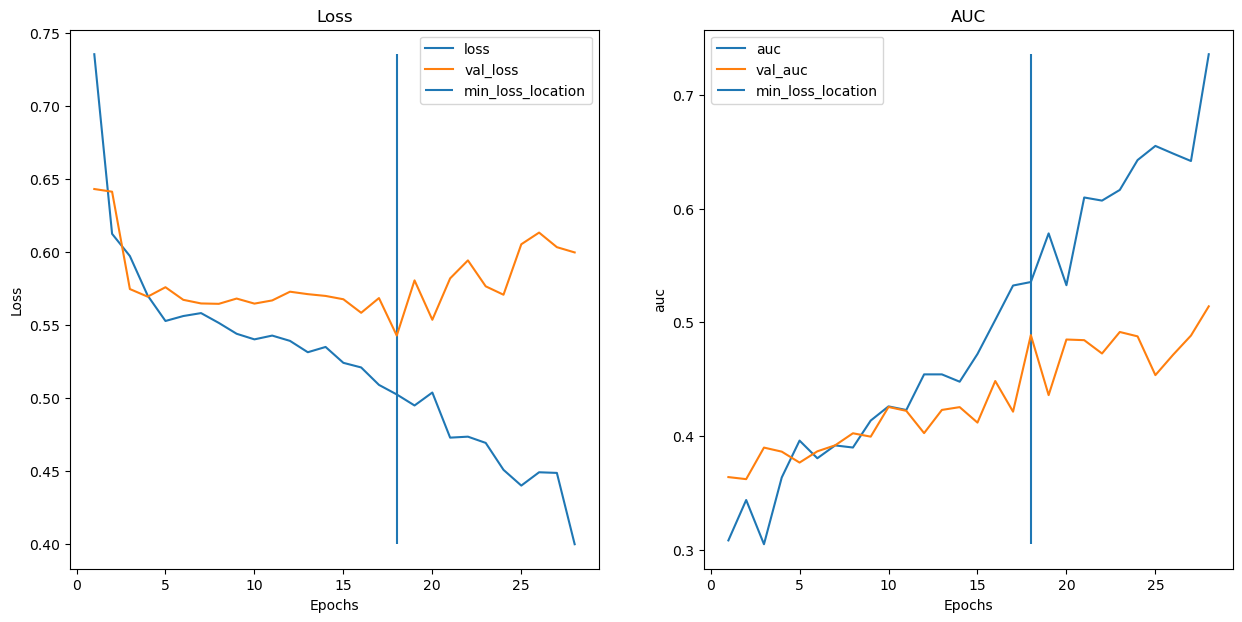

In [35]:
plot_training_curves_auc(history=first_model_tuned.model_hist)

In [43]:
import itertools
def get_permutations():
    tuning1 = [i*.02 for i in range(int(1/0.02))]
    param_comb = []
    for subset in itertools.permutations(tuning1, 1):
        param_comb.append(subset)
    return param_comb

In [50]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, average_precision_score, roc_auc_score

In [52]:
all_scores = []
for params in get_permutations():
    #all_model_predictions = []
    #all_model_raw_scores = []
    #all_actuals = []
    all_model_predictions = [1 if prediction > params[0] else 0 for prediction in result]
    #all_model_predictions.extend(model_prediction)
    #all_model_raw_scores.extend(model[1][0])
    #all_actuals.extend(model[1][1])
    scores = {}
    scores['accuracy'] = accuracy_score(val_y, all_model_predictions)
    scores['recall'] = recall_score(val_y, all_model_predictions)
    scores['precision'] = precision_score(val_y, all_model_predictions)
    scores['f1_score'] = f1_score(val_y, all_model_predictions)
    scores['pr_auc'] = average_precision_score(val_y, result) #pr_auc
    scores['auc'] = roc_auc_score(val_y, result)
    all_scores.append((scores,params))

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
max_f1 = all_scores[0] 
for idx, score in enumerate(all_scores):
    if score[0]['f1_score'] > max_f1[0]['f1_score']:
        print(idx)
        max_f1 = score
max_f1

1
2
3
4
5
6
7
8
12
14


({'accuracy': 0.7032520325203252,
  'recall': 0.6376811594202898,
  'precision': 0.4782608695652174,
  'f1_score': 0.5465838509316769,
  'pr_auc': 0.5204699222676306,
  'auc': 0.7256202407270941},
 (0.28,))